# Структура
* 1. [Подготовка данных (Предварительный анализ)](#podgotovka)
* 2. [Проверка системы сплитования](#proverka)
* 3. [Анализ результатов ААБ Теста](#analis)
    * 3.1 Общие показатели (Был ли эксперимент успешен в целом)
    * 3.2 [Анализ характеристик групп пользователей](#groups)
        * 3.2.1 [Гендерный состав](#gender)
        * 3.2.2 [Привлекательность](#attraction)
        * 3.2.3 [Количество посещений](#visits)
        * 3.2.4 [Страны](#country)
        * 3.2.5 [Возраст](#ages)
* 4. [Выводы](#vivod) 

# Подготовка данных (Предварительный анализ)<a name="podgotovka"></a>

In [1]:
import pandas as pd
import numpy as np
# from datetime import timedelta
#from datetime import datetime
# from io import StringIO

In [2]:
import seaborn as sns
from scipy import stats
from scipy.stats import levene
# from scipy.stats import wilcoxon
import matplotlib.pyplot as plt


In [191]:
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import scikit_posthocs as sp

In [9]:
# from sklearn.linear_model import LinearRegression

In [4]:
from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')

In [5]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
): 
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc =-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars: 
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]: 
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {  # "boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [1]:
import requests
from urllib.parse import urlencode

In [2]:
def get_df_by_yandex_link(link, name): 
    base_url = 'https: //cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = link  # This inscribe your link
    # Get the download link
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get (final_url)
    download_url = response.json()['href']
    # Load the file and save it
    download_response = requests.get(download_url)
    with open(name, 'wb') as f:  # Here specify the correct path to the file
        f.write(download_response.content)

In [3]:
yandex_links = ['https: //disk.yandex.ru/d/4XXIME4osGrMRA', 'https: //disk.yandex.ru/d/gvCWpZ55ODzs2g'
                'https: //disk.yandex.ru/d/yJFydMNNGkEKfg', 'https: //disk.yandex.ru/d/VY5W0keMX5TZBQ'
                'https: //disk.yandex.ru/d/br6KkQupzzTGoQ', 'https: //disk.yandex.ru/d/th5GL0mGOc-qzg']

In [4]:
names = ['users_test', 'transactions_test', 'users_control_1.csv', 'transactions_control_1.csv',
         'users_control_2.csv', 'transactions_control_2.csv']

In [ ]:
h = 0
for i in yandex_links: 
    name = names[i]
    get_df_by_yandex_link(i, name)
    h += 1

In [6]:
users_test = pd.read_csv('users_test.csv', sep=';')
transactions_test = pd.read_csv('transactions_test.csv', sep=';')

users_control_1 = pd.read_csv('users_control_1.csv', sep=';')
transactions_control_1 = pd.read_csv('transactions_control_1.csv', sep=';')

users_control_2 = pd.read_csv('users_control_2.csv', sep=';')
transactions_control_2 = pd.read_csv('transactions_control_2.csv', sep=';')

In [69]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [7]:
transactions_control_1 = transactions_control_1.dropna()

In [63]:
nunique_comparison = pd.concat([users_test.nunique().to_frame(),
                                users_control_1.nunique().to_frame(),
                                users_control_2.nunique().to_frame()],
                                axis=1)

In [64]:
nunique_comparison.columns = ['test', 'control_1', 'control_2']

In [75]:
nunique_comparison.loc[['uid', 'country', 'age', 'views_count', 'attraction_coeff']]

,test,control_1,control_2
uid,4308,4340,4264
country,51,40,45
age,57,56,59
views_count,331,339,328
attraction_coeff,600,587,585


**Для начала необходимо убедиться в корректной настройке системы сплитования. Выше в таблице представлено сравнение уникальных значений для id, стран, возраста, параметров привлекательности пользователей. В связи с тем, что во второй контрольной группе представлено на 5 стран больше, чем в первой можно сделать предположение о целосообразности попарного сравнения результатов вместо однофакторного дисперсионного анализа. Однако необходимо уточнить состав стран и количество пользователей, соответствующее каждой стране**

# 2. Проверка системы сплитования<a name="proverka"></a>

In [91]:
country_comparison = pd.concat([users_control_2.groupby('country').agg({'uid': 'count'})
                    .sort_values('uid', ascending=False), users_control_1.groupby('country').agg({'uid': 'count'})
                    .sort_values('uid', ascending=False)], \
                    axis=1)

In [93]:
country_comparison.columns = ['control_2', 'control_1']

In [100]:
country_comparison.query("control_2=='NaN' | control_1=='NaN'").sum()

control_2    24.0
control_1    19.0
dtype: float64

**В первой контрольной группе присутствует 19 пользователей из стран, которые не представлены во второй группе. И 24 пользователя соответственно во второй.**

In [102]:
country_comparison.head(15)

,control_2,control_1
United States of America,1486.0,1471.0
Argentina,397.0,389.0
France,376.0,370.0
Spain,310.0,342.0
Italy,293.0,338.0
Chile,286.0,287.0
United Arab Emirates,211.0,207.0
Germany,202.0,188.0
United Kingdom (Great Britain),146.0,146.0
Canada,134.0,134.0


**Удельная доля пользователей из уникальных для каждой контрольной группы стран позволяет проводить дальнейший анализ данных.** 

**Дополнительно сравним различия в страницах откуда пользователь перешел на страницу оплаты.**

In [49]:
from_page_comparison = pd.concat([transactions_test.groupby('from_page').agg({'payment_id': 'count'}),
                                  transactions_control_1.groupby('from_page').agg({'payment_id': 'count'}),
                                  transactions_control_2.groupby('from_page').agg({'payment_id': 'count'})],
                                  axis=1)

In [50]:
from_page_comparison.columns = ['test', 'control_1', 'control_2']

In [8]:
from_page_comparison.query("control_2=='NaN' | control_1=='NaN' | test=='NaN'")

,test,control_1,control_2
coins_popup,1.0,2.0,NaN
delivery_vip,1.0,NaN,NaN
empty_mutual,1.0,NaN,1.0
likes,1.0,NaN,NaN
super_popup,2.0,2.0,NaN
admins,NaN,2.0,NaN
empty_admins,NaN,5.0,NaN
no_sympathy,NaN,2.0,NaN
refund_VP,NaN,1.0,NaN
refund_WP,NaN,1.0,NaN


In [54]:
from_page_comparison['average'] = from_page_comparison.test + from_page_comparison.control_1 \
                                                            + from_page_comparison.control_2

In [58]:
from_page_comparison.sort_values('average', ascending=False).head(7)

,test,control_1,control_2,average
empty_likes,72.0,99.0,101.0,272.0
trial_vip_popup,48.0,56.0,45.0,149.0
none,34.0,34.0,32.0,100.0
autoreply_message,27.0,29.0,24.0,80.0
menu,27.0,31.0,14.0,72.0
promo_09,18.0,21.0,22.0,61.0
autorefill,5.0,23.0,20.0,48.0


**Количество пользователей, перешедших с уникальных для каждой группы страниц, существенно не влияет  на однородность составов групп.**

In [47]:
age_comparison = pd.concat([users_test.groupby('gender').agg({'uid': 'count'}),
                            users_control_1.groupby('gender').agg({'uid': 'count'}),
                            users_control_2.groupby('gender').agg({'uid': 'count'})],
                            axis=1)

In [48]:
age_comparison.columns = ['test', 'control_1', 'control_2']

In [49]:
age_comparison = age_comparison.T

In [62]:
age_df = pd.DataFrame({'test': (age_comparison.loc['test'][0] / age_comparison.loc['test'].sum()).round(3),
          'control_1': (age_comparison.loc['control_1'][0] / age_comparison.loc['control_1'].sum()).round(3),
          'control_2': (age_comparison.loc['control_2'][0] / age_comparison.loc['control_2'].sum()).round(3)},
          index=['age_relation'])

In [63]:
age_df

,test,control_1,control_2
age_relation,0.047,0.042,0.046


**Отношение количества пользователей определенного пола к другому примерно одинаковое во всех трех группах.**

In [141]:
pd.DataFrame({'test': (users_test.age_filter_start.mean().round(3), users_test.age_filter_end.mean().round(3)),
     'control_1': (users_control_1.age_filter_start.mean().round(3), users_control_1.age_filter_end.mean().round(3)),
    'control_2': (users_control_2.age_filter_start.mean().round(3), users_control_2.age_filter_end.mean().round(3))},
            index=['age_filter_start_mean', 'age_filter_end_mean'])

,test,control_1,control_2
age_filter_start_mean,26.701,26.794,26.954
age_filter_end_mean,38.249,38.553,38.907


**Средний возраст в фильтрах поиска также совпадает во всех случаях**

In [82]:
stats.kstest(list(transactions_control_1[transactions_control_1.product_type=='coins'].revenue), \
                  list(transactions_control_2[transactions_control_2.product_type=='coins'].revenue))

KstestResult(statistic=0.1674063650140723, pvalue=0.038402920239277494)

**Дополнительная проверка системы сплитования в части распределений выручки за внутреннюю валюту для последующего пофакторного анализа (пункт 3.1).
Cтатистика теста равна 0.167, а соответствующее значение p равно .038.Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что два выборочных набора из контрольных групп не происходят из одного и того же распределения.**

In [8]:
aa1 = np.array([[users_control_2.is_premium.sum(), users_control_2.shape[0] - users_control_2.is_premium.sum()],
                [users_control_1.is_premium.sum(), users_control_1.shape[0] - users_control_1.is_premium.sum()]])

In [9]:
print(stats.chi2_contingency(aa1, correction=False)[1])

0.9008571305798496


**Тестирование данных АА теста показывает отсутствие значимых различий в контрольных группах**

In [12]:
control_full = pd.concat([users_control_1, users_control_2],
                          axis=0)

In [13]:
control_transactions_full = pd.concat([transactions_control_1, transactions_control_2], axis=0)

In [96]:
control_transactions_full.shape[0], transactions_test.shape[0]

(705, 273)

In [16]:
control_full['group'] = 'control'

In [17]:
users_test['group'] = 'test'

In [18]:
full_data = pd.concat([control_full, users_test],
                       axis=0)

# Анализ результатов ААБ Теста<a name="analis"></a>
## 3.1 Общие показатели (Был ли эксперимент успешен в целом)

In [134]:
general_indicators = pd.DataFrame({'Control': [control_full.was_premium.sum() / control_full.uid.nunique(),
                                    control_full.is_premium.sum() / control_full.uid.nunique(),
                                    control_full.total_revenue.sum() / control_full.uid.nunique()],
                                    'Test': [users_test.was_premium.sum() / users_test.uid.nunique(),
                                    users_test.is_premium.sum() / users_test.uid.nunique(),
                                    users_test.total_revenue.sum() / users_test.uid.nunique()]},
                                    index=['ex_premiums_on_uid', 'premiums_on_uid', 'revenue_on_uid'])

In [135]:
general_indicators

,Control,Test
ex_premiums_on_uid,0.098443,0.094708
premiums_on_uid,0.044514,0.036444
revenue_on_uid,523.210716,534.080316


**Предварительный расчет таких показателей как количество клиентов с бывшей и действующей подпиской на пользователя и выручки на количество пользователей (ARPU).**

In [24]:
pd.DataFrame({'control_full': (control_full[control_full.total_revenue  !=  0].shape[0], control_full.shape[0]),
              'test': (users_test[users_test.total_revenue  !=  0].shape[0], users_test.shape[0])},
              index=['clients', 'users'])

,control_full,test
clients,379,146
users,8604,4308


**Относительно небольшой процент клиентов из пользователей совершили покупки**

In [137]:
levene(list(users_test.total_revenue),
       list(control_full.total_revenue),
       center='mean')

LeveneResult(statistic=0.09659654815825328, pvalue=0.7559577996728548)

**Проверим имеют ли выборки данных о выручке равные дисперсии. Р-значение составляет более 0,05. Это означает, что целесообразно не отвергать нулевую гипотезу, требование гомогенности дисперсий удовлетворено для последующего дисперсионного анализа средних нормированной выручки.**

In [136]:
stats.f_oneway(list(users_test.total_revenue),
               list(control_full.total_revenue))

F_onewayResult(statistic=0.011111300162398436, pvalue=0.916051998389317)

**Так как p-значение больше 0.05, то мы не отвергаем нулевую гипотезу и делаем вывод, что средние выручки для групп значимо не отличаются.**

In [40]:
stats.shapiro(np.log(control_full[control_full.total_revenue != 0].total_revenue))

ShapiroResult(statistic=0.9119991064071655, pvalue=4.6361325152163846e-14)

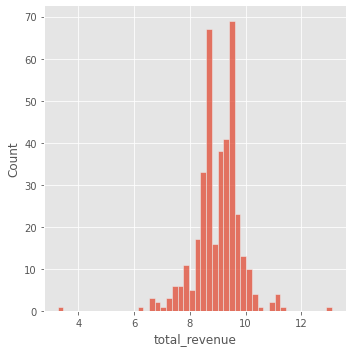

In [38]:
sns.displot(np.log(control_full[control_full.total_revenue != 0].total_revenue), kde=False)

**Нулевая гипотеза в случае Шапиро-Уилка — нормальность распределения, распределение выручки для контрольной группы явно отклоняется от нормального (даже без учета нулей), аналогично и в тестовой группе**

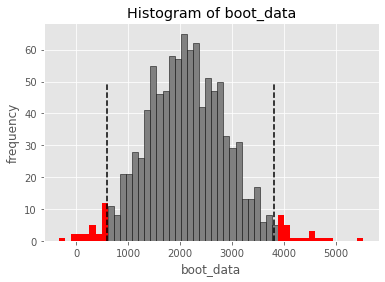

{'quants':                  0
 0.025   592.916667
 0.975  3809.320238,
 'p_value': 0.007911663832772245}

In [138]:
get_bootstrap(
    transactions_test.revenue,  # числовые значения первой выборки
    control_transactions_full.revenue,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика (средние)
    bootstrap_conf_level=0.95)  # уровень значимости 

In [139]:
stats.ks_2samp(transactions_test.revenue, control_transactions_full.revenue)

KstestResult(statistic=0.25656612890655445, pvalue=6.844746991419015e-12)

**Однако согласно данным о транзакциях разница в средних значениях выручки подтверждается вышеуказанными бутстрап-тестом и проверкой по критерию Колмогорова-Смирнова**

In [47]:
premchi = np.array([[users_test.is_premium.sum(), users_test.shape[0] - users_test.is_premium.sum()],
                [control_full.is_premium.sum(), control_full.shape[0] - control_full.is_premium.sum()]])

In [48]:
print(stats.chi2_contingency(premchi, correction=False)[1])

0.030770049237882124


**Дополнительно проведем попарное сравнение наличия действующей подписки у пользователей в тестовой и контрольной группах. 
p-value менее уровня 5% подтверждает статзначимые различия между тестовой и контрольной группами. Таким образом цену за подписку повысили, выручка увеличилась, но количество подписок уменьшилось.**

#### Далее попробуем найти различия в группах пользователей по типу продукта

In [124]:
product_type_comparison_avg = pd.concat([control_transactions_full.groupby('product_type')
                                                                  .agg({'revenue': lambda x: x.mean().round(2)}),
                                     transactions_test.groupby('product_type')
                                                                  .agg({'revenue': lambda x: x.mean().round(2)})],
                                     axis=1)

In [125]:
product_type_comparison_avg.columns = ['control', 'test']

In [126]:
product_type_comparison_avg

,control,test
product_type,,
coins,4669.67,5341.28
other_type,3203.65,5786.79
premium_no_trial,7155.25,10667.18
trial_premium,11805.84,12906.48


In [117]:
pt_comp = pd.DataFrame({'control_payments': control_transactions_full.groupby('product_type')
                                                                     .agg({'payment_id': 'count'}).payment_id,
                        'control_uids':control_transactions_full.groupby('product_type').agg({'uid': 'nunique'}).uid,
                        'test_payments': transactions_test.groupby('product_type')
                                                          .agg({'payment_id': 'count'}).payment_id,
                        'test_uids': transactions_test.groupby('product_type').agg({'uid': 'nunique'}).uid},
                        index=['coins', 'other_type', 'premium_no_trial', 'trial_premium'])

In [127]:
pt_comp['control_payments_on_uid'] = (pt_comp.control_payments / pt_comp.control_uids).round(2)
pt_comp['test_payments_on_uid'] = (pt_comp.test_payments / pt_comp.test_uids).round(2)

In [128]:
pt_comp

,control_payments,control_uids,test_payments,test_uids,control_payments_on_uid,test_payments_on_uid
coins,273,134,106,52,2.04,2.04
other_type,99,63,29,19,1.57,1.53
premium_no_trial,213,201,76,67,1.06,1.13
trial_premium,120,120,62,61,1.00,1.02


**Сравнение средней выручки по типу продукта показывает увеличение показателей относительно контрольной группы. Количество платежей на пользователя при этом не отличается.**

In [173]:
users_test.merge(transactions_test, on=['uid'], how='left').isna().groupby('uid').sum().payment_id

uid
False    4162
Name: payment_id, dtype: int64

In [146]:
round(((users_test.shape[0] - 4162) / users_test.shape[0] * 100), 2)

3.39

In [174]:
control_full.merge(control_transactions_full, on=['uid'], how='left').isna().groupby('uid').sum().payment_id

uid
False    8224
Name: payment_id, dtype: int64

In [152]:
round(((control_full.shape[0] - 8224) / control_full.shape[0] * 100), 2)

4.42

**Процент конверсии в покупку уменьшился приблизительно на 1% (доля клиентов от пользователей)**

In [170]:
users_test.query("was_premium == 1 & is_premium == 1").shape[0] / users_test.shape[0] * 100

3.6443825441039928

In [171]:
control_full.query("was_premium == 1 & is_premium == 1").shape[0] / control_full.shape[0] * 100

4.451417945141794

**Приблизительно на 0,8 уменьшился процент клиентов, не отменивших премиум подписку.**

In [178]:
transactions_test

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium
...,...,...,...,...,...,...,...,...
268,891419625,Israel,2017-04-11 05:58:00,2017-11-11 08:33:00,14352,147,trial_vip_popup,trial_premium
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial
270,891497073,United States of America,2017-02-11 15:33:00,2017-05-11 04:06:00,2730,67,empty_likes,other_type
271,891406224,Israel,2017-04-11 12:56:00,2017-04-11 13:35:00,2743,67,empty_likes,other_type


In [180]:
transactions_test.joined_at = pd.to_datetime(transactions_test.joined_at,
                                             format='%Y-%m-%d %H:%M:%S')

In [181]:
transactions_test.paid_at = pd.to_datetime(transactions_test.paid_at,
                                             format='%Y-%m-%d %H:%M:%S') 

In [182]:
transactions_test['join_pay_diff'] = transactions_test.paid_at - transactions_test.joined_at

In [92]:
transactions_test.join_pay_diff.median()

Timedelta('2 days 07:32:00')

In [183]:
control_transactions_full.joined_at = pd.to_datetime(control_transactions_full.joined_at,
                                                  format='%Y-%m-%d %H:%M:%S')

In [184]:

control_transactions_full.paid_at = pd.to_datetime(control_transactions_full.paid_at,
                                                format='%Y-%m-%d %H:%M:%S') 

In [185]:
control_transactions_full['join_pay_diff'] = control_transactions_full.paid_at - control_transactions_full.joined_at

In [188]:
control_transactions_full.join_pay_diff.median()

Timedelta('1 days 20:09:00')

**Медианная разница времени между регистрацией и покупкой увеличилась примерно на 11 часов.**

# 3.2 Анализ характеристик групп пользователей<a name="groups"></a>
## 3.2.1 Гендерный состав

In [193]:
age_rev_by_gender = pd.concat([control_full.groupby('gender').agg({'total_revenue': lambda x: x.mean().round(2)}),
                               users_test.groupby('gender').agg({'total_revenue': lambda x: x.mean().round(2)})],
                               axis=1)

In [196]:
age_rev_by_gender.columns = ['control', 'test']

In [197]:
age_rev_by_gender

,control,test
gender,,
0,228.83,134.05
1,536.70,553.76


In [198]:
total_revenue_comparison = pd.concat([users_test.groupby('gender').agg({'total_revenue': 'sum'}),
                                      control_full.groupby('gender').agg({'total_revenue': 'sum'})],
                                      axis=1)

In [199]:
total_revenue_comparison.columns = ['control', 'test']

In [200]:
total_revenue_comparison

,control,test
gender,,
0,27079,86268
1,2273739,4415437


In [201]:
pd.DataFrame({'test': (users_test[users_test.gender == 1].query("total_revenue != 0").shape[0],
                  users_test[users_test.gender == 0].query("total_revenue != 0").shape[0]),
              'control': (control_full[control_full.gender == 1].query("total_revenue != 0").shape[0],
                  control_full[control_full.gender == 0].query("total_revenue != 0").shape[0])},
              index=['clients_gender_1', 'clients_gender_0'])

,test,control
clients_gender_1,144,368
clients_gender_0,2,11


**У пользователей с гендером 0 средняя выручка упала, но общая выросла. Для дальнейшего анализа представляется недостаточное количество наблюдений (2 и 11 клиентов соответственно).**

In [15]:
levene(list(users_test[users_test.gender == 1].total_revenue),
       list(users_test[users_test.gender == 0].total_revenue),
       list(control_full[control_full.gender == 1].total_revenue),
       list(control_full[control_full.gender == 0].total_revenue),
       center='mean')

LeveneResult(statistic=2.8122497712907233, pvalue=0.0378387352504359)

**С учетом того, что дисперсии внутри наших групп отличаются (требование гомогенности дисперсий не удовлетворено) целесообразно провести тест Крускала-Уоллиса.** 

In [22]:
stats.kruskal(users_test[users_test.gender == 1].total_revenue, users_test[users_test.gender == 0].total_revenue,
    control_full[control_full.gender == 1].total_revenue, control_full[control_full.gender == 0].total_revenue)

KruskalResult(statistic=12.456189155495212, pvalue=0.005973163205387405)

**Согласно значению pvalue нулевая гипотеза теста "медиана одинакова для всех групп" не может быть отвергнута.**

In [24]:
merged_test = transactions_test.merge(users_test, on=['uid'], how='left')
merged_control = control_transactions_full.merge(control_full, on=['uid'], how='left')

In [28]:
stats.kruskal(merged_test[merged_test.gender == 1].revenue,
              merged_test[merged_test.gender == 0].revenue,
              merged_control[merged_control.gender == 1].revenue,
              merged_control[merged_control.gender == 0].revenue)

KruskalResult(statistic=20.038378762655764, pvalue=0.0001666619546593342)

**В данных по транзакциям статистически значимые отличия имеются**

In [34]:
p_values_gender = sp.posthoc_dunn([merged_test[merged_test.gender == 1].revenue,
                                   merged_test[merged_test.gender == 0].revenue,
                                   merged_control[merged_control.gender == 1].revenue,
                                   merged_control[merged_control.gender == 0].revenue], p_adjust='bonferroni')

In [35]:
p_values_gender < 0.05

,1,2,3,4
1,False,False,True,False
2,False,False,False,False
3,True,False,False,False
4,False,False,False,False


**Отличия в выручке значимы только для гендера 1**

## 3.2.2 Привлекательность<a name="attraction"></a>

In [57]:
general_indicators

,Test,Control_1,Control_2
ex_premiums_on_uid,0.094708,0.100461,0.096388
premiums_on_uid,0.036444,0.044240,0.044794
revenue_on_uid,534.080316,594.761982,450.384146


In [37]:
print(stats.spearmanr(list(users_test.attraction_coeff),
                      list(users_test.total_revenue)), ',',
      stats.spearmanr(list(control_full.attraction_coeff),
                      list(control_full.total_revenue)))

SpearmanrResult(correlation=0.05513051498203405, pvalue=0.00029435922237452814) , SpearmanrResult(correlation=0.04848306859709989, pvalue=6.821842348228197e-06)


**Распределения значений не являются нормальными, принимается решение о выборе коэффициента ранговой корреляции r-Спирмена. Выявлена значительная положительная корреляция между коэффициентом привлекательности и выручкой, которую можно не учитывать в силу величину коэффициента.**

In [41]:
full_merged_data = pd.concat([merged_test, merged_control], axis=0)

Text(0, 0.5, 'Выручка')

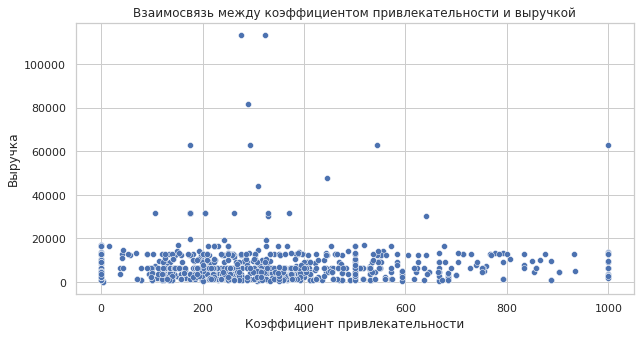

In [42]:
sns.set(style='whitegrid', rc={'figure.figsize': (10, 5)})
sns.scatterplot(x='attraction_coeff', y='revenue', data=full_merged_data)
plt.title('Взаимосвязь между коэффициентом привлекательности и выручкой')
plt.xlabel('Коэффициент привлекательности')
plt.ylabel('Выручка')

In [43]:
stats.spearmanr(list(full_merged_data.attraction_coeff),
                list(full_merged_data.revenue))

SpearmanrResult(correlation=0.006456503565335202, pvalue=0.8401840513916059)

In [45]:
full_data.attraction_coeff.quantile(q=[0.4, 0.7, 1])

0.4     113.4
0.7     500.0
1.0    1000.0
Name: attraction_coeff, dtype: float64

*В имеющихся данных большое количество пользователей с коэффициентом равным нулю,  методом подбора можно определить вышеуказанные границы групп пользователей*

In [46]:
group1 = merged_test.query('attraction_coeff < 113').revenue 
group2 = merged_test.query('113 < attraction_coeff < 500').revenue 
group3 = merged_test.query('attraction_coeff > 500').revenue 
group4 = merged_control.query('attraction_coeff < 113').revenue 
group5 = merged_control.query('113 < attraction_coeff < 500').revenue 
group6 = merged_control.query('attraction_coeff > 500').revenue 

In [47]:
stats.kruskal(group1, group2, group3, group4, group5, group6)

KruskalResult(statistic=26.09664700361864, pvalue=8.546583881232363e-05)

**Если результаты теста Краскела-Уоллиса статистически значимы, целесообразно провести тест Данна, чтобы точно определить, какие группы отличаются.**

In [48]:
p_values_coeff = sp.posthoc_dunn([group1, group2, group3, group4, group5, group6], p_adjust='bonferroni')

In [50]:
p_values_coeff < 0.05

,1,2,3,4,5,6
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,True,False,False,False,True
6,False,False,False,False,True,False


**В представленной таблице нас интересуют пары 1-4, 2-5, 3-6. Для группы пользователей с коэффициентом привлекательности от 113 до 500 имеются статистически значимые различия.**

## 3.2.3 Количество посещений<a name="visits"></a>

In [52]:
data_for_split = full_data[['uid', 'visit_days', 'total_revenue', 'group']] 

In [53]:
data_for_split = data_for_split.fillna(0)

In [65]:
data_for_split["total_days"] = (data_for_split.visit_days.astype(str).apply(lambda x: x.split(',')[-1])).astype(int)

In [66]:
data_for_split.head()

,uid,visit_days,total_revenue,group,total_days
0,892319115,"1,2,3,4,5,6",0,control,6
1,891248523,"1,2",0,control,2
2,891670932,"1,2,3,5,6,8,9,11,13,16",0,control,16
3,891060786,"1,2,3,4,5",0,control,5
4,892006554,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",0,control,19


In [56]:
stats.spearmanr(list(data_for_split.total_days),
                list(data_for_split.total_revenue))

SpearmanrResult(correlation=0.08801189806338636, pvalue=1.2531552460446705e-23)

In [58]:
avg_rev_per_days = data_for_split.groupby('total_days').agg({'total_revenue': 'mean'}) \
                                 .rename(columns={'total_revenue': 'avg_revenue'}) \
                                 .sort_values('avg_revenue', ascending=False) \
                                 .reset_index() \
                                 .head(10)

In [59]:
avg_rev_per_days

,total_days,avg_revenue
0,28,4875.216667
1,15,3202.663043
2,27,2146.054054
3,25,2009.913043
4,60,1914.972222
5,26,1817.531646
6,29,1708.032258
7,20,1611.878505
8,24,1487.792079
9,16,1337.562814


In [60]:
print(avg_rev_per_days.total_days.astype('float64').mean().round(0), ',',
      avg_rev_per_days.total_days.astype('float64').std().round(1))

27.0 , 12.6


**Для топ 10 групп пользователей по средней выручке, которые провели Х дней в приложении, среднее количество дней в приложении - 27. \
Стандартное отклонение при этом составило 12 дней. Таким образом стоит уделять внимание группе пользователей, посетивших приложение от 15 до 29 дней.**

In [85]:
stats.kruskal(data_for_split[data_for_split.group == 'control'].query('15 < total_days < 29').total_revenue,
              data_for_split[data_for_split.group == 'test'].query('15 < total_days < 29').total_revenue,
              data_for_split[data_for_split.group == 'control']
                  .query('total_days < 15 | total_days > 29').total_revenue,
              data_for_split[data_for_split.group == 'test']
                  .query('total_days < 15 | total_days > 29').total_revenue)

KruskalResult(statistic=149.80777008634732, pvalue=2.898903854513447e-32)

In [81]:
p_values_days = sp.posthoc_dunn([data_for_split[data_for_split.group == 'control']
                                 .query('15 < total_days < 29').total_revenue,
                                 data_for_split[data_for_split.group == 'test']
                                 .query('15 < total_days < 29').total_revenue,
                                 data_for_split[data_for_split.group == 'control']
                                 .query('total_days < 15 | total_days > 29').total_revenue,
                                 data_for_split[data_for_split.group == 'test']
                                 .query('total_days < 15 | total_days > 29').total_revenue], p_adjust='bonferroni')

In [84]:
p_values_days < 0.05

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


**Различия в выручке для выбранного диапазона посещаемости приложения значимы для тестовой и контрольных групп**

## 3.2.4 Страны<a name="country"></a>

In [90]:
country_rev_avg = pd.concat([control_full.groupby('country').agg({'total_revenue': 'mean'})
                                                   .sort_values('total_revenue', ascending=False),
                                    users_test.groupby('country').agg({'total_revenue': 'mean'})
                                                   .sort_values('total_revenue', ascending=False)],
                                    axis=1)

In [91]:
country_rev_avg.columns = ['control', 'test']

In [96]:
country_rev_avg['avg_rev_diff'] = country_rev_avg.test - country_rev_avg.control

In [97]:
country_rev_avg[country_rev_avg.rev_diff > 0].sort_values('avg_rev_diff', ascending=False)

,control,test,rev_diff,avg_rev_diff
Mexico,0.000000,887.714286,887.714286,887.714286
Spain,449.138037,948.265781,499.127744,499.127744
United Arab Emirates,460.971292,945.951327,484.980036,484.980036
France,446.949062,706.454039,259.504977,259.504977
Germany,244.633333,459.789474,215.156140,215.156140
Argentina,338.049618,474.795455,136.745836,136.745836
United States of America,438.922557,497.819310,58.896754,58.896754
Canada,457.425373,463.255474,5.830101,5.830101


**Необходимо проверить является ли статзначимой разница в распределении выручки за премиум подписки по странам Spain, UA Emirates, France, Germany, Argentina, USA.**

In [101]:
country_list = ['Spain', 'United Arab Emirates', 'France', 'Germany', 'Argentina', 'United States of America']

In [104]:
country_df = full_merged_data.query("country_x == @country_list")

In [112]:
country_group_1 = country_df[country_df.group == 'control'].query("country_x == 'Spain'").revenue
country_group_2 = country_df[country_df.group == 'control'].query("country_x == 'United Arab Emirates'").revenue
country_group_3 = country_df[country_df.group == 'control'].query("country_x == 'France'").revenue
country_group_4 = country_df[country_df.group == 'control'].query("country_x == 'Germany'").revenue
country_group_5 = country_df[country_df.group == 'control'].query("country_x == 'Argentina'").revenue
country_group_6 = country_df[country_df.group == 'control'].query("country_x == 'United States of America'").revenue

country_group_7 = country_df[country_df.group == 'test'].query("country_x == 'Spain'").revenue
country_group_8 = country_df[country_df.group == 'test'].query("country_x == 'United Arab Emirates'").revenue
country_group_9 = country_df[country_df.group == 'test'].query("country_x == 'France'").revenue
country_group_10 = country_df[country_df.group == 'test'].query("country_x == 'Germany'").revenue
country_group_11 = country_df[country_df.group == 'test'].query("country_x == 'Argentina'").revenue
country_group_12 = country_df[country_df.group == 'test'].query("country_x == 'United States of America'").revenue

In [113]:
stats.kruskal(country_group_1, country_group_2, country_group_3,
              country_group_4, country_group_5, country_group_6,
              country_group_7, country_group_8, country_group_9,
              country_group_10, country_group_11, country_group_12)

KruskalResult(statistic=34.12054072740245, pvalue=0.000345633734617267)

In [116]:
country_values = sp.posthoc_dunn([country_group_1, country_group_2, country_group_3,
                 country_group_4, country_group_5, country_group_6,
                 country_group_7, country_group_8, country_group_9,
                 country_group_10, country_group_11, country_group_12], p_adjust='bonferroni') < 0.05

In [124]:
country_values.iloc[6:12, 0:6]

,1,2,3,4,5,6
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False
11,False,False,True,False,True,True
12,False,False,False,False,False,False


**По результатам теста значимые отличия обнаружены только для страны Argentina**

## 3.2.5 Возраст<a name="ages"></a>

In [126]:
print(stats.spearmanr(list(users_test.age),
            list(users_test.total_revenue))[1].round(3), ',',
      stats.spearmanr(list(control_full.age),
            list(control_full.total_revenue))[1].round(3))

0.052 , 0.31


**Коэффициенты корреляции между возрастом пользователя статистически не значимы**

In [127]:
print('Границы возрастного диапазона: ', full_data.age.min(), '-', full_data.age.max())

Границы возрастного диапазона:  16 - 99


In [128]:
for_labels = ['16-20', '21-26', '27-32', '33-38', '39-46', '46-55', '56-99']
for_bins = [15, 20, 26, 32, 38, 46, 55, 100]

In [137]:
full_merged_data = full_merged_data.assign(
                   age_group=pd.cut(full_merged_data['age'], bins=for_bins, labels=for_labels))

In [140]:
formula = 'revenue ~ group + age_group + group: age_group'
model = ols(formula, full_merged_data).fit()
aov_table = anova_lm(model, typ=2)

In [141]:
print(aov_table)

                       sum_sq     df          F    PR(>F)
group            1.024304e+09    1.0  13.829121  0.000212
age_group        4.613758e+08    6.0   1.038172  0.398802
group:age_group  4.177482e+08    6.0   0.940002  0.465265
Residual         7.140219e+10  964.0        NaN       NaN


**Как видно по последней колонке, эффект фактора age_group и взаимодействие факторов не значимы.**

Text(0, 0.5, 'Выручка')

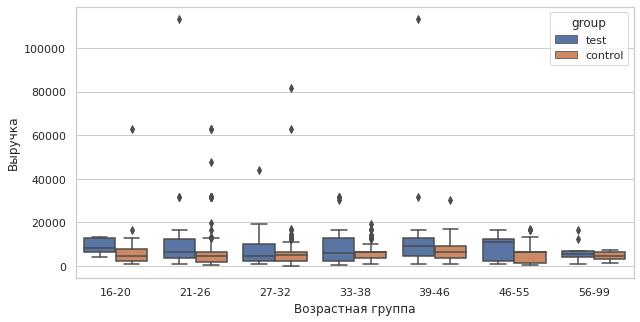

In [142]:
sns.boxplot(x='age_group', y='revenue', hue='group', data=full_merged_data)
plt.xlabel('Возрастная группа')
plt.ylabel('Выручка')

In [184]:
age_group_1 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '16-20'").revenue
age_group_2 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '21-26'").revenue
age_group_3 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '27-32'").revenue
age_group_4 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '33-38'").revenue
age_group_5 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '39-46'").revenue
age_group_6 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '46-55'").revenue
age_group_7 = full_merged_data[full_merged_data.group == 'control'].query("age_group == '56-99'").revenue

age_group_8 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '16-20'").revenue
age_group_9 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '21-26'").revenue
age_group_10 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '27-32'").revenue
age_group_11 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '33-38'").revenue
age_group_12 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '39-46'").revenue
age_group_13 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '46-55'").revenue
age_group_14 = full_merged_data[full_merged_data.group == 'test'].query("age_group == '56-99'").revenue

In [185]:
age_pvalues = sp.posthoc_dunn([age_group_1, age_group_2, age_group_3, age_group_4, age_group_5, age_group_6,
                               age_group_7, age_group_8, age_group_9, age_group_10, age_group_11, age_group_12,
                               age_group_13, age_group_14], p_adjust='bonferroni') < 0.05

In [186]:
age_pvalues.iloc[7:14, 0:7]

,1,2,3,4,5,6,7
8,False,True,False,False,False,False,False
9,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False
12,False,True,False,False,False,False,False
13,False,False,False,False,False,False,False
14,False,False,False,False,False,False,False


**В выбранных возрастных группах статистически значимых отличий не обнаружено**

# 4. Выводы<a name="vivod"></a>
**В целом эксперимент был успешен. Для тестовой группы стоимость подписки была повышена (ARPPU увеличилась, количество премиум-подписок на пользователя сократилось), но изменение выручки от увеличения стоимости подписки больше, чем от сокращения количества клиентов.**

**Нововведение имеет смысл для следующих групп:**
   *  Пользователи гендера 1 
   *  Посетившие приложение от 15 до 29 дней
   *  Пользователи из страны Argentina
   *  С коэффициентом привлекательности от 113 до 500